In [1]:
import pandas as pd
from common.local_constants import region_warehouse_codes

In [2]:
import os
os.chdir('..')
print(os.getcwd())

/Users/ahmedjawad/RDX/Xdemand


In [3]:
from common.db_connection import engine
from sqlalchemy import text

In [4]:
query = f"""SELECT * FROM agg_im_sku_daily_sales 
where sku in (select distinct sku from stat_forecast_data_quantity) and date > DATEADD(year, -3, GETDATE()) order by sku, region, date;"""
with engine.connect() as con:
    daily_sales = pd.read_sql_query(query, con)

In [5]:

daily_sales['date']=pd.to_datetime(pd.to_datetime(daily_sales['date']).dt.date)
# Fulfillment by Merchant
daily_sales['sku'] = daily_sales['sku'].str.replace('^M-', '', regex=True)
daily_sales['year']=daily_sales['date'].dt.year
daily_sales['month']=daily_sales['date'].dt.month
daily_sales['year_month'] = daily_sales['date'].dt.to_period('M')
daily_sales['revenue'] = daily_sales['revenue'].astype(float)

daily_sales

,date,sku,region,channel,promotional rebates,quantity,revenue,price,year,month,year_month
0,2022-07-10,3PBR-F6MB-5FT,UK,Amazon,0.00,4,175.96,43.990000,2022,7,2022-07
1,2022-07-12,3PBR-F6MB-5FT,UK,Amazon,5.49,5,219.95,43.990000,2022,7,2022-07
2,2022-07-13,3PBR-F6MB-5FT,UK,Amazon,1.83,3,131.97,43.990000,2022,7,2022-07
3,2022-07-14,3PBR-F6MB-5FT,UK,Amazon,0.00,1,43.99,43.990000,2022,7,2022-07
4,2022-07-15,3PBR-F6MB-5FT,UK,Amazon,1.83,2,87.98,43.990000,2022,7,2022-07
...,...,...,...,...,...,...,...,...,...,...,...
126447,2024-07-26,WGS-F6U-M,UK,Amazon,0.00,5,44.95,8.990000,2024,7,2024-07
126448,2024-07-27,WGS-F6U-M,UK,Amazon,0.00,4,35.96,8.990000,2024,7,2024-07
126449,2024-07-28,WGS-F6U-M,UK,Amazon,0.00,1,8.99,8.990000,2024,7,2024-07
126450,2024-07-29,WGS-F6U-M,UK,Amazon,0.00,4,35.96,8.990000,2024,7,2024-07


In [6]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle,  random
from tqdm import tqdm
from datetime import datetime, timedelta

import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
df=daily_sales.copy(deep=True)

In [7]:
def gap_finder(ts):
    
    # this function finds gaps and calculates their length:
    # note ts: 0 = day with sales, 1 = days with 0 sales
    
    for i, gap in enumerate(ts):
        if gap == 0: 
            continue
        elif i!=0: 
            ts[i] += ts[i-1]
            if ts[i-1]!=0: ts[i-1] = -1
    return ts

In [8]:
df['warehouse_code'] = df['region'].replace(region_warehouse_codes)
df=df.groupby(['channel','sku','warehouse_code','date'])[['quantity']].sum().reset_index()
df

,channel,sku,warehouse_code,date,quantity
0,Amazon,3PBR-F6MB-5FT,UK,2022-07-10,4
1,Amazon,3PBR-F6MB-5FT,UK,2022-07-12,5
2,Amazon,3PBR-F6MB-5FT,UK,2022-07-13,3
3,Amazon,3PBR-F6MB-5FT,UK,2022-07-14,1
4,Amazon,3PBR-F6MB-5FT,UK,2022-07-15,2
...,...,...,...,...,...
126447,Amazon,WGS-F6U-M,UK,2024-07-26,5
126448,Amazon,WGS-F6U-M,UK,2024-07-27,4
126449,Amazon,WGS-F6U-M,UK,2024-07-28,1
126450,Amazon,WGS-F6U-M,UK,2024-07-29,4


In [9]:
def fill_missing_dates(df_sku):
    min_date = df_sku['date'].min()
    max_date = df_sku['date'].max()
    idx = pd.date_range(min_date, max_date)
    df_sku = df_sku.set_index('date').reindex(idx).rename_axis('date').reset_index()
    df_sku['sku'] = df_sku['sku'].fillna(method='ffill')
    df_sku['warehouse_code'] = df_sku['warehouse_code'].fillna(method='ffill')
    df_sku['channel'] = df_sku['channel'].fillna(method='ffill')

    df_sku['quantity'] = df_sku['quantity'].fillna(0)
    return df_sku


# Group by SKU and apply the function to fill missing dates
df_filled = df.groupby(['sku','warehouse_code']).apply(fill_missing_dates).reset_index(drop=True)

# Fill in missing values for the remaining columns
df_filled['quantity'] = df_filled['quantity'].fillna(0)


# Display the resulting DataFrame
print(df_filled)



             date channel            sku warehouse_code  quantity
0      2022-07-10  Amazon  3PBR-F6MB-5FT             UK       4.0
1      2022-07-11  Amazon  3PBR-F6MB-5FT             UK       0.0
2      2022-07-12  Amazon  3PBR-F6MB-5FT             UK       5.0
3      2022-07-13  Amazon  3PBR-F6MB-5FT             UK       3.0
4      2022-07-14  Amazon  3PBR-F6MB-5FT             UK       1.0
...           ...     ...            ...            ...       ...
143249 2024-07-27  Amazon      WGS-F6U-M             UK       4.0
143250 2024-07-28  Amazon      WGS-F6U-M             UK       1.0
143251 2024-07-29  Amazon      WGS-F6U-M             UK       4.0
143252 2024-07-30  Amazon      WGS-F6U-M             UK       0.0
143253 2024-07-31  Amazon      WGS-F6U-M             UK       3.0

[143254 rows x 5 columns]


In [10]:
df_filled[df_filled['quantity']==0]

,date,channel,sku,warehouse_code,quantity
1,2022-07-11,Amazon,3PBR-F6MB-5FT,UK,0.0
6,2022-07-16,Amazon,3PBR-F6MB-5FT,UK,0.0
7,2022-07-17,Amazon,3PBR-F6MB-5FT,UK,0.0
10,2022-07-20,Amazon,3PBR-F6MB-5FT,UK,0.0
11,2022-07-21,Amazon,3PBR-F6MB-5FT,UK,0.0
...,...,...,...,...,...
143111,2024-03-11,Amazon,WGS-F6U-M,UK,0.0
143150,2024-04-19,Amazon,WGS-F6U-M,UK,0.0
143163,2024-05-02,Amazon,WGS-F6U-M,UK,0.0
143224,2024-07-02,Amazon,WGS-F6U-M,UK,0.0


In [11]:
grid_df=df_filled.copy(deep=True)


In [12]:
grid_df[grid_df['quantity']==0]

,date,channel,sku,warehouse_code,quantity
1,2022-07-11,Amazon,3PBR-F6MB-5FT,UK,0.0
6,2022-07-16,Amazon,3PBR-F6MB-5FT,UK,0.0
7,2022-07-17,Amazon,3PBR-F6MB-5FT,UK,0.0
10,2022-07-20,Amazon,3PBR-F6MB-5FT,UK,0.0
11,2022-07-21,Amazon,3PBR-F6MB-5FT,UK,0.0
...,...,...,...,...,...
143111,2024-03-11,Amazon,WGS-F6U-M,UK,0.0
143150,2024-04-19,Amazon,WGS-F6U-M,UK,0.0
143163,2024-05-02,Amazon,WGS-F6U-M,UK,0.0
143224,2024-07-02,Amazon,WGS-F6U-M,UK,0.0


In [13]:
grid_df['gaps'] = (~(grid_df['quantity'] > 0)).astype(int)
grid_df[grid_df['gaps']>0]

,date,channel,sku,warehouse_code,quantity,gaps
1,2022-07-11,Amazon,3PBR-F6MB-5FT,UK,0.0,1
6,2022-07-16,Amazon,3PBR-F6MB-5FT,UK,0.0,1
7,2022-07-17,Amazon,3PBR-F6MB-5FT,UK,0.0,1
10,2022-07-20,Amazon,3PBR-F6MB-5FT,UK,0.0,1
11,2022-07-21,Amazon,3PBR-F6MB-5FT,UK,0.0,1
...,...,...,...,...,...,...
143111,2024-03-11,Amazon,WGS-F6U-M,UK,0.0,1
143150,2024-04-19,Amazon,WGS-F6U-M,UK,0.0,1
143163,2024-05-02,Amazon,WGS-F6U-M,UK,0.0,1
143224,2024-07-02,Amazon,WGS-F6U-M,UK,0.0,1


In [14]:
prods = list(grid_df.sku.unique())
s_list = [] #list to hold gaps in days
e_list = [] #list to hold expected values of gaps
p_list = [] #list to hold avg probability of no sales

In [15]:
# Group by SKU and calculate the min and max date for each SKU
total_days = df_filled.groupby(['sku','warehouse_code'])['date'].agg(['min', 'max']).reset_index()

# Calculate the date difference and store it in a new column
total_days['total_days'] = (total_days['max'] - total_days['min']).dt.days

total_days

,sku,warehouse_code,min,max,total_days
0,3PBR-F6MB-5FT,UK,2022-07-10,2024-07-31,752
1,4PBR-F6MB-5FT,UK,2022-07-28,2024-07-31,734
2,APR-T1B,UK,2022-06-16,2024-07-31,776
3,BGR-F6MB-10OZ,DE,2022-06-01,2024-07-31,791
4,BGR-F6MB-10OZ,UK,2022-06-01,2024-07-31,791
...,...,...,...,...,...
194,WGS-F6P-S,UK,2022-06-01,2024-07-31,791
195,WGS-F6R-L,UK,2022-07-22,2024-07-31,740
196,WGS-F6R-M,UK,2022-11-06,2024-08-01,634
197,WGS-F6U-L,UK,2022-06-01,2024-07-31,791


In [16]:
total_days_dict = dict(zip(total_days[['sku','warehouse_code']], total_days['total_days']))
# Create the dictionary
total_days_dict = {(row['sku'], row['warehouse_code']): row['total_days'] for _, row in total_days.iterrows()}

# Print the dictionary
print(total_days_dict)

{('3PBR-F6MB-5FT', 'UK'): 752, ('4PBR-F6MB-5FT', 'UK'): 734, ('APR-T1B', 'UK'): 776, ('BGR-F6MB-10OZ', 'DE'): 791, ('BGR-F6MB-10OZ', 'UK'): 791, ('BGR-F6MB-12OZ', 'DE'): 791, ('BGR-F6MB-12OZ', 'UK'): 791, ('BGR-F6MB-14OZ', 'DE'): 790, ('BGR-F6MB-14OZ', 'UK'): 792, ('BGR-F6MB-16OZ', 'DE'): 792, ('BGR-F6MB-16OZ', 'UK'): 791, ('BGR-F6MB-8OZ', 'UK'): 790, ('BGR-F6MGL-10OZ', 'UK'): 791, ('BGR-F6MGL-12OZ', 'UK'): 791, ('BGR-F6MGL-14OZ', 'UK'): 791, ('BGR-F6MGL-16OZ', 'UK'): 792, ('BGR-F6MP-10OZ', 'UK'): 792, ('BGR-F6MP-12OZ', 'UK'): 791, ('BGR-F6MR-12OZ', 'UK'): 791, ('BGR-F6MR-14OZ', 'UK'): 789, ('BGR-F6MR-16OZ', 'UK'): 791, ('BGR-F6MW-12OZ', 'UK'): 790, ('BGR-F6MW-14OZ', 'DE'): 791, ('BGR-F6MW-14OZ', 'UK'): 790, ('BGR-F6MW-16OZ', 'UK'): 789, ('FPR-F6MB', 'DE'): 790, ('FPR-F6MB', 'UK'): 785, ('FPR-F6MGL', 'DE'): 779, ('FPR-F6MGL', 'UK'): 791, ('FPR-F6MR', 'DE'): 791, ('FPR-F6MR', 'UK'): 790, ('FPR-F6MW', 'DE'): 791, ('FPR-T1RB', 'UK'): 788, ('GGR-F12B-L', 'DE'): 792, ('GGR-F12B-L', 'UK'): 7

In [17]:
for prod_id, dfx in tqdm(grid_df.groupby(["sku",'warehouse_code'])):   
    # extract gap_series for a prod_id
    sales_gaps = dfx.loc[:,'gaps']

    # calculate initial probability
    zero_days = sum(sales_gaps)
    p = zero_days / total_days_dict[(prod_id[0], prod_id[1])]

    # find and mark gaps
    accum_add_prod = np.frompyfunc(lambda x, y: int((x+y)*y), 2, 1)
    sales_gaps[:] = accum_add_prod.accumulate(dfx["gaps"], dtype=np.object).astype(int)
    sales_gaps[sales_gaps < sales_gaps.shift(-1)] = np.NaN
    sales_gaps = sales_gaps.fillna(method="bfill").fillna(method='ffill')
    s_list += [sales_gaps]
    
    # calculate E/total_days for all possible gap lengths:
    gap_length = sales_gaps.unique()
    
    d = {length: ((1-p**length)/(p**length*(1-p)))/365 for length in gap_length}
    sales_E_years = sales_gaps.map(d)
    
    # cut out supply_gap days and run recursively
    p1 = 0
    while p1 < p:
        
        if p1!=0:
            p=p1
        
        # once in 100 years event; change to your taste here
        gap_days = sum(sales_E_years>100)
            
        p1 = (zero_days-gap_days+0.0001)/(total_days_dict[prod_id]-gap_days)
        
        d = {length: ((1-p1**length)/(p1**length*(1-p1)))/365 for length in gap_length}
        sales_E_years = sales_gaps.map(d)
        
    # add results to list it turns out masked replacemnt is a very expensive operation in pandas, so better do it in one go
    e_list += [sales_E_years]
    p_list += [pd.Series(p,index=sales_gaps.index)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 479.80it/s]


In [18]:
# add it to grid_df in one go fast!:
grid_df['gap_days'] = pd.concat(s_list)
grid_df['gap_e'] = pd.concat(e_list)
grid_df['sale_prob'] = pd.concat(p_list)
##45664
# Dump to pickle:
grid_df.to_pickle('grid_part_1_gaps.pkl')

In [19]:
# becuase we have some really extreme values lets take a log:
grid_df['gap_e_log10'] = np.log10((grid_df['gap_e'].values+1))

In [20]:
grid_df['dept_id'] = grid_df['sku'].str.split('-').str.get(0)
grid_df['item_id'] = grid_df['sku'].str.split('-').str.get(1)


# e over 100 years does not make much sense
m = grid_df['gap_e_log10']>2
grid_df.loc[m,'gap_e_log10']=2

# take a subsample to vizualise:
np.random.seed(19)
depts = list(grid_df.dept_id.unique())

prod_list = []
for d in depts:
    prod_by_dept=grid_df['item_id'][grid_df.dept_id == d].unique()
    prod_list += list(np.random.choice(prod_by_dept,5))
    
m = grid_df.item_id.isin(prod_list)
viz_df = grid_df[m]
viz_df.head()

,date,channel,sku,warehouse_code,quantity,gaps,gap_days,gap_e,sale_prob,gap_e_log10,dept_id,item_id
0,2022-07-10,Amazon,3PBR-F6MB-5FT,UK,4.0,0,1.0,0.055479,0.049383,0.02345,3PBR,F6MB
1,2022-07-11,Amazon,3PBR-F6MB-5FT,UK,0.0,1,1.0,0.055479,0.049383,0.02345,3PBR,F6MB
2,2022-07-12,Amazon,3PBR-F6MB-5FT,UK,5.0,0,0.0,0.000000,0.049383,0.00000,3PBR,F6MB
3,2022-07-13,Amazon,3PBR-F6MB-5FT,UK,3.0,0,0.0,0.000000,0.049383,0.00000,3PBR,F6MB
4,2022-07-14,Amazon,3PBR-F6MB-5FT,UK,1.0,0,0.0,0.000000,0.049383,0.00000,3PBR,F6MB


In [21]:
viz_df=viz_df[['sku','warehouse_code','date','gaps','gap_days','gap_e','sale_prob','gap_e_log10']]
one_year_ago = datetime.today() - timedelta(days=365)
viz_df = viz_df[viz_df['date'] > one_year_ago]
max_date=max(daily_sales['date'])
max_date
viz_df['last_data_seen']=max_date

In [22]:
viz_df.dtypes

sku                       object
warehouse_code            object
date              datetime64[ns]
gaps                       int64
gap_days                 float64
gap_e                    float64
sale_prob                float64
gap_e_log10              float64
last_data_seen    datetime64[ns]
dtype: object

In [23]:
viz_df = viz_df.replace([np.inf, -np.inf], 0)
viz_df

,sku,warehouse_code,date,gaps,gap_days,gap_e,sale_prob,gap_e_log10,last_data_seen
399,3PBR-F6MB-5FT,UK,2023-08-13,0,0.0,0.0,0.049383,0.0,2024-08-01
400,3PBR-F6MB-5FT,UK,2023-08-14,0,0.0,0.0,0.049383,0.0,2024-08-01
401,3PBR-F6MB-5FT,UK,2023-08-15,0,0.0,0.0,0.049383,0.0,2024-08-01
402,3PBR-F6MB-5FT,UK,2023-08-16,0,0.0,0.0,0.049383,0.0,2024-08-01
403,3PBR-F6MB-5FT,UK,2023-08-17,0,0.0,0.0,0.049383,0.0,2024-08-01
...,...,...,...,...,...,...,...,...,...
141665,WGS-F6R-M,UK,2024-07-28,0,0.0,0.0,0.203470,0.0,2024-08-01
141666,WGS-F6R-M,UK,2024-07-29,0,0.0,0.0,0.203470,0.0,2024-08-01
141667,WGS-F6R-M,UK,2024-07-30,0,0.0,0.0,0.203470,0.0,2024-08-01
141668,WGS-F6R-M,UK,2024-07-31,0,0.0,0.0,0.203470,0.0,2024-08-01


In [24]:
viz_df.to_sql('stat_stock_out_past', engine, if_exists='replace', index=False)

190

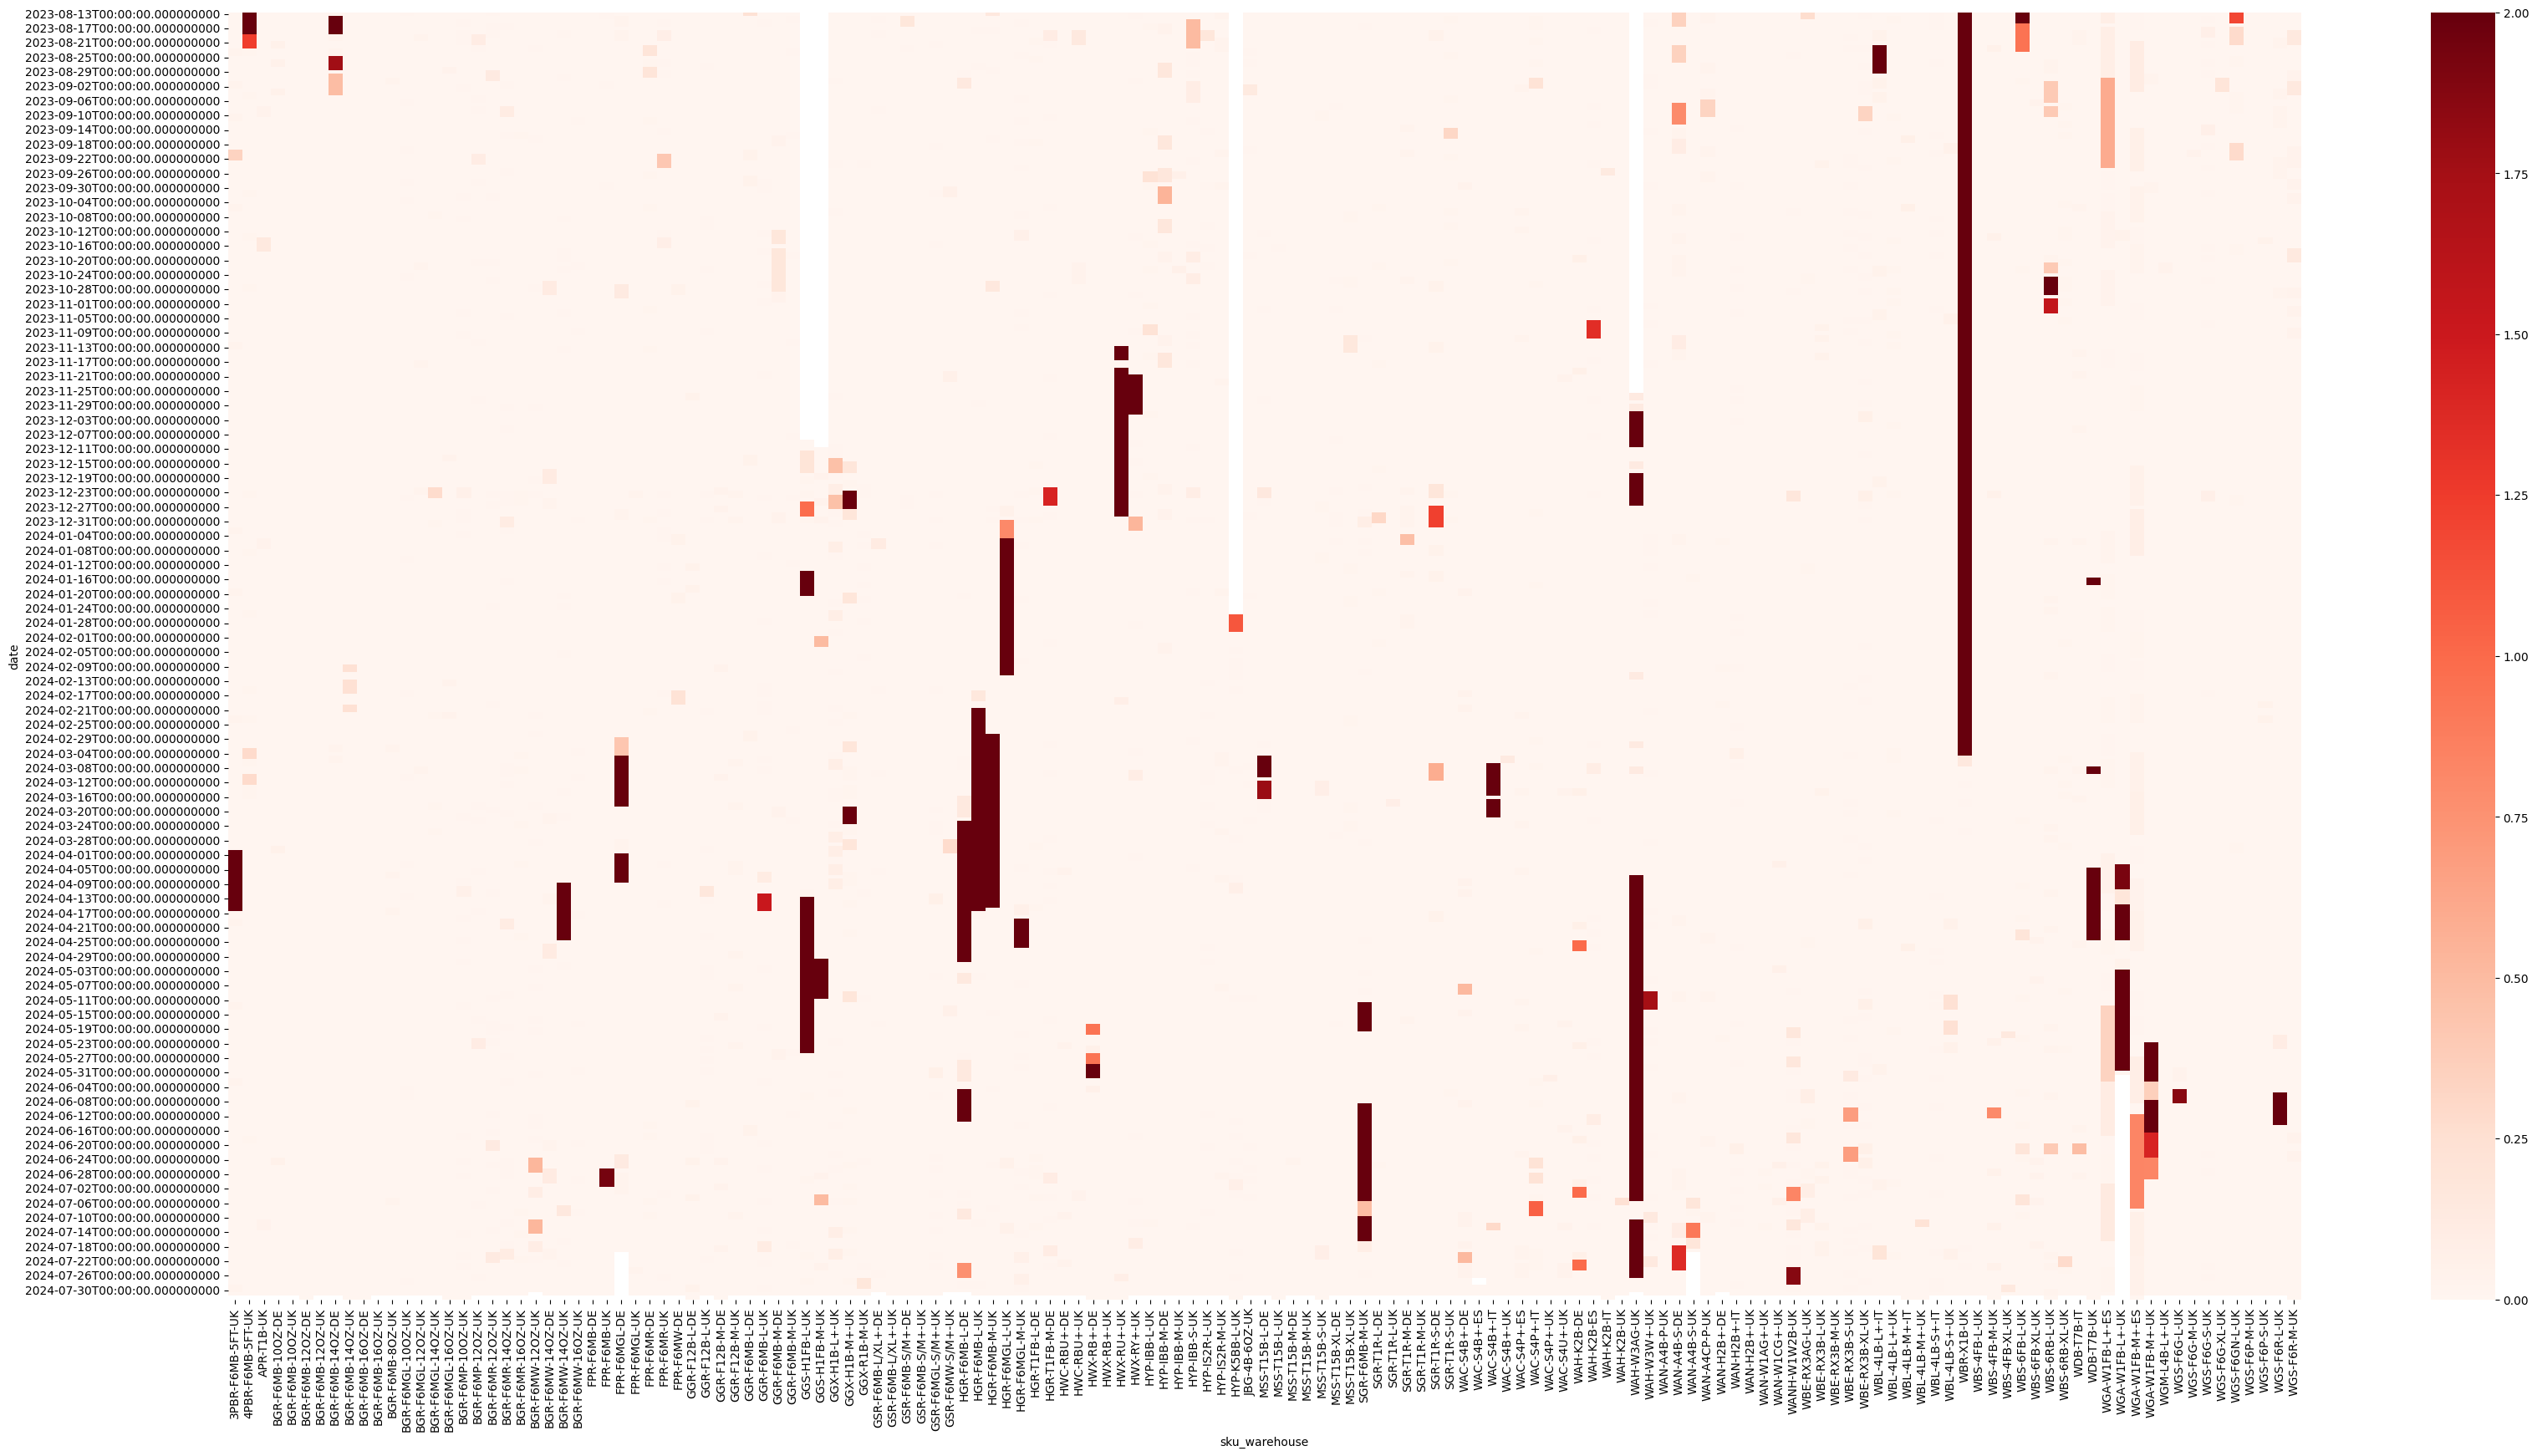

In [25]:
viz_df['sku_warehouse'] = viz_df['sku'] + '-' + viz_df['warehouse_code']

v_df = viz_df.pivot(index='date', columns='sku_warehouse', values='gap_e_log10')
v_df = v_df.reindex(sorted(v_df.columns), axis=1)
f, ax = plt.subplots(figsize=(40, 20))
temp = sns.heatmap(v_df, cmap='Reds')
plt.savefig('stockout.png')
plt.show()